In [2]:
import scipy.io as sio

filepath = r"E:\4 Paper\3. Milling\mill.mat"

data = sio.loadmat(filepath)

print("Keys stored in the .mat file:")
for key in data.keys():
    print(key)


Keys stored in the .mat file:
__header__
__version__
__globals__
mill


In [3]:
import scipy.io as sio
import numpy as np

filepath = r"E:\4 Paper\3. Milling\mill.mat"
mat = sio.loadmat(filepath)

mill = mat["mill"]
print("mill type:", type(mill), "shape:", mill.shape)

# If it's a MATLAB struct, its dtype will have field names:
print("dtype:", mill.dtype)

if isinstance(mill, np.ndarray) and mill.dtype.names is not None:
    print("\nField names inside mill:")
    for name in mill.dtype.names:
        print(" -", name)


mill type: <class 'numpy.ndarray'> shape: (1, 167)
dtype: [('case', 'O'), ('run', 'O'), ('VB', 'O'), ('time', 'O'), ('DOC', 'O'), ('feed', 'O'), ('material', 'O'), ('smcAC', 'O'), ('smcDC', 'O'), ('vib_table', 'O'), ('vib_spindle', 'O'), ('AE_table', 'O'), ('AE_spindle', 'O')]

Field names inside mill:
 - case
 - run
 - VB
 - time
 - DOC
 - feed
 - material
 - smcAC
 - smcDC
 - vib_table
 - vib_spindle
 - AE_table
 - AE_spindle


In [4]:
import scipy.io as sio
import numpy as np
import pywt
import matplotlib.pyplot as plt

# --- load .mat file ---
filepath = r"E:\4 Paper\3. Milling\mill.mat"
mat = sio.loadmat(filepath)
mill = mat["mill"]  # shape (1, 167), structured array

n_samples = mill.shape[1]
print("num records:", n_samples)

# helper to unpack a field into a plain Python list
def extract_field(field_name, cast=float):
    """Extract 1D list from MATLAB struct field mill[field_name]."""
    arr = []
    field = mill[field_name]  # shape (1, n_samples), dtype=object
    for i in range(n_samples):
        v = field[0, i]
        v = np.array(v).squeeze()
        if v.size == 1:
            arr.append(cast(v))
        else:
            arr.append(v.astype(float))
    return arr

# scalar info
VB_all       = np.array(extract_field("VB", cast=float))          # flank wear
DOC_all      = np.array(extract_field("DOC", cast=float))
feed_all     = np.array(extract_field("feed", cast=float))
material_all = np.array(extract_field("material", cast=int))

# AE signal – I’ll use spindle AE (closer to tool)
AE_spindle_all = extract_field("AE_spindle", cast=float)

print("VB range:", VB_all.min(), "to", VB_all.max())
print("Example AE length:", AE_spindle_all[0].shape)


num records: 167
VB range: nan to nan
Example AE length: (9000,)


In [5]:
# 1 = cast iron, 2 = steel (from paper)
STEEL = 2

steel_mask = (material_all == STEEL)
VB_steel = VB_all[steel_mask]
AE_steel = [sig for sig, m in zip(AE_spindle_all, material_all) if m == STEEL]

# sort by increasing VB
idx = np.argsort(VB_steel)
VB_steel_sorted = VB_steel[idx]
AE_steel_sorted = [AE_steel[i] for i in idx]

print("Steel samples:", len(AE_steel_sorted))


Steel samples: 58


In [18]:
import numpy as np
import scipy.io
import pywt
from scipy import signal as scipy_signal
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [19]:
def load_nasa_ames_data(filepath):
    print("="*70)
    print("LOADING NASA AMES MILLING DATASET")
    print("="*70)
    
    mat_data = scipy.io.loadmat(filepath)
    mill = mat_data['mill']
    
    n_samples = mill.shape[1]
    print(f"Total samples: {n_samples}")
    
    data = {
        'steel': {'samples': [], 'wear': [], 'cases': []},
        'cast_iron': {'samples': [], 'wear': [], 'cases': []}
    }
    
    for i in range(n_samples):
        sample = mill[0, i]
        case = int(sample['case'][0, 0])
        vb = float(sample['VB'][0, 0])
        material = int(sample['material'][0, 0])
        ae_signal = sample['AE_table'].flatten()
        
        material_type = 'cast_iron' if material == 1 else 'steel'
        data[material_type]['samples'].append(ae_signal)
        data[material_type]['wear'].append(vb)
        data[material_type]['cases'].append(case)
    
    for material_type in ['steel', 'cast_iron']:
        wear_array = np.array(data[material_type]['wear'])
        sort_idx = np.argsort(wear_array)
        data[material_type]['samples'] = [data[material_type]['samples'][i] for i in sort_idx]
        data[material_type]['wear'] = [data[material_type]['wear'][i] for i in sort_idx]
        data[material_type]['cases'] = [data[material_type]['cases'][i] for i in sort_idx]
    
    print(f"Steel: {len(data['steel']['samples'])} samples")
    print(f"Cast Iron: {len(data['cast_iron']['samples'])} samples")
    print("="*70)
    return data

filepath = r"E:\4 Paper\3. Milling\mill.mat"
data = load_nasa_ames_data(filepath)

LOADING NASA AMES MILLING DATASET
Total samples: 167
Steel: 58 samples
Cast Iron: 109 samples


In [20]:
def wavelet_packet_decomposition(sig, wavelet='coif1', level=3):
    wp = pywt.WaveletPacket(data=sig, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = {}
    node_list = [node.path for node in wp.get_level(level, 'freq')]
    
    for i, path in enumerate(node_list):
        node = wp[path]
        reconstructed = node.reconstruct(update=False)
        
        if len(reconstructed) > len(sig):
            reconstructed = reconstructed[:len(sig)]
        elif len(reconstructed) < len(sig):
            reconstructed = np.pad(reconstructed, (0, len(sig) - len(reconstructed)))
        
        nodes[i] = reconstructed
    
    return nodes

test_signal = data['steel']['samples'][0]
test_nodes = wavelet_packet_decomposition(test_signal)
print(f"✅ WPT complete: {len(test_nodes)} nodes created")

✅ WPT complete: 8 nodes created


In [21]:
def calculate_spsse(sig, fs=50000):
    # FIXED: Use scipy_signal.welch instead of signal.welch
    freqs, psd = scipy_signal.welch(sig, fs=fs, nperseg=1024)
    
    total_power = np.sum(psd)
    if total_power == 0:
        return 0
    
    probabilities = psd / total_power
    probabilities = probabilities[probabilities > 0]
    
    if len(probabilities) == 0:
        return 0
    
    shannon_entropy = -np.sum(probabilities * np.log2(probabilities))
    spsse = total_power / shannon_entropy if shannon_entropy > 0 else 0
    
    return spsse

# Test
test_spsse = calculate_spsse(test_nodes[0])
print(f"✅ SPSSE test: {test_spsse:.6f}")

✅ SPSSE test: 0.000030


In [22]:
def select_wear_symptomatic_node(data, material_type='steel', fs=50000, level=3, TR1=0.3):
    print(f"\nSelecting node for {material_type.upper()}...")
    
    samples = data[material_type]['samples']
    wear_levels = np.array(data[material_type]['wear'])
    num_nodes = 2 ** level
    spsse_matrix = np.zeros((len(samples), num_nodes))
    
    for sample_idx, ae_signal in enumerate(samples):
        nodes = wavelet_packet_decomposition(ae_signal, level=level)
        for node_idx in range(num_nodes):
            spsse_matrix[sample_idx, node_idx] = calculate_spsse(nodes[node_idx], fs)
        
        if (sample_idx + 1) % 20 == 0:
            print(f"  Processed {sample_idx + 1}/{len(samples)}")
    
    normal_mask = wear_levels < TR1
    wear_mask = wear_levels >= TR1
    growth_ratios = np.zeros(num_nodes)
    
    for node_idx in range(num_nodes):
        normal_mean = np.mean(spsse_matrix[normal_mask, node_idx])
        wear_mean = np.mean(spsse_matrix[wear_mask, node_idx])
        if normal_mean > 0:
            growth_ratios[node_idx] = wear_mean / normal_mean
    
    selected_node = np.argmax(growth_ratios)
    
    print(f"✅ Selected Node: {selected_node}")
    print(f"   Growth Ratio: {growth_ratios[selected_node]:.3f}")
    
    return selected_node, spsse_matrix, growth_ratios

material_type = 'steel'
selected_node, spsse_matrix, growth_ratios = select_wear_symptomatic_node(data, material_type)


Selecting node for STEEL...
  Processed 20/58
  Processed 40/58
✅ Selected Node: 4
   Growth Ratio: 2.676


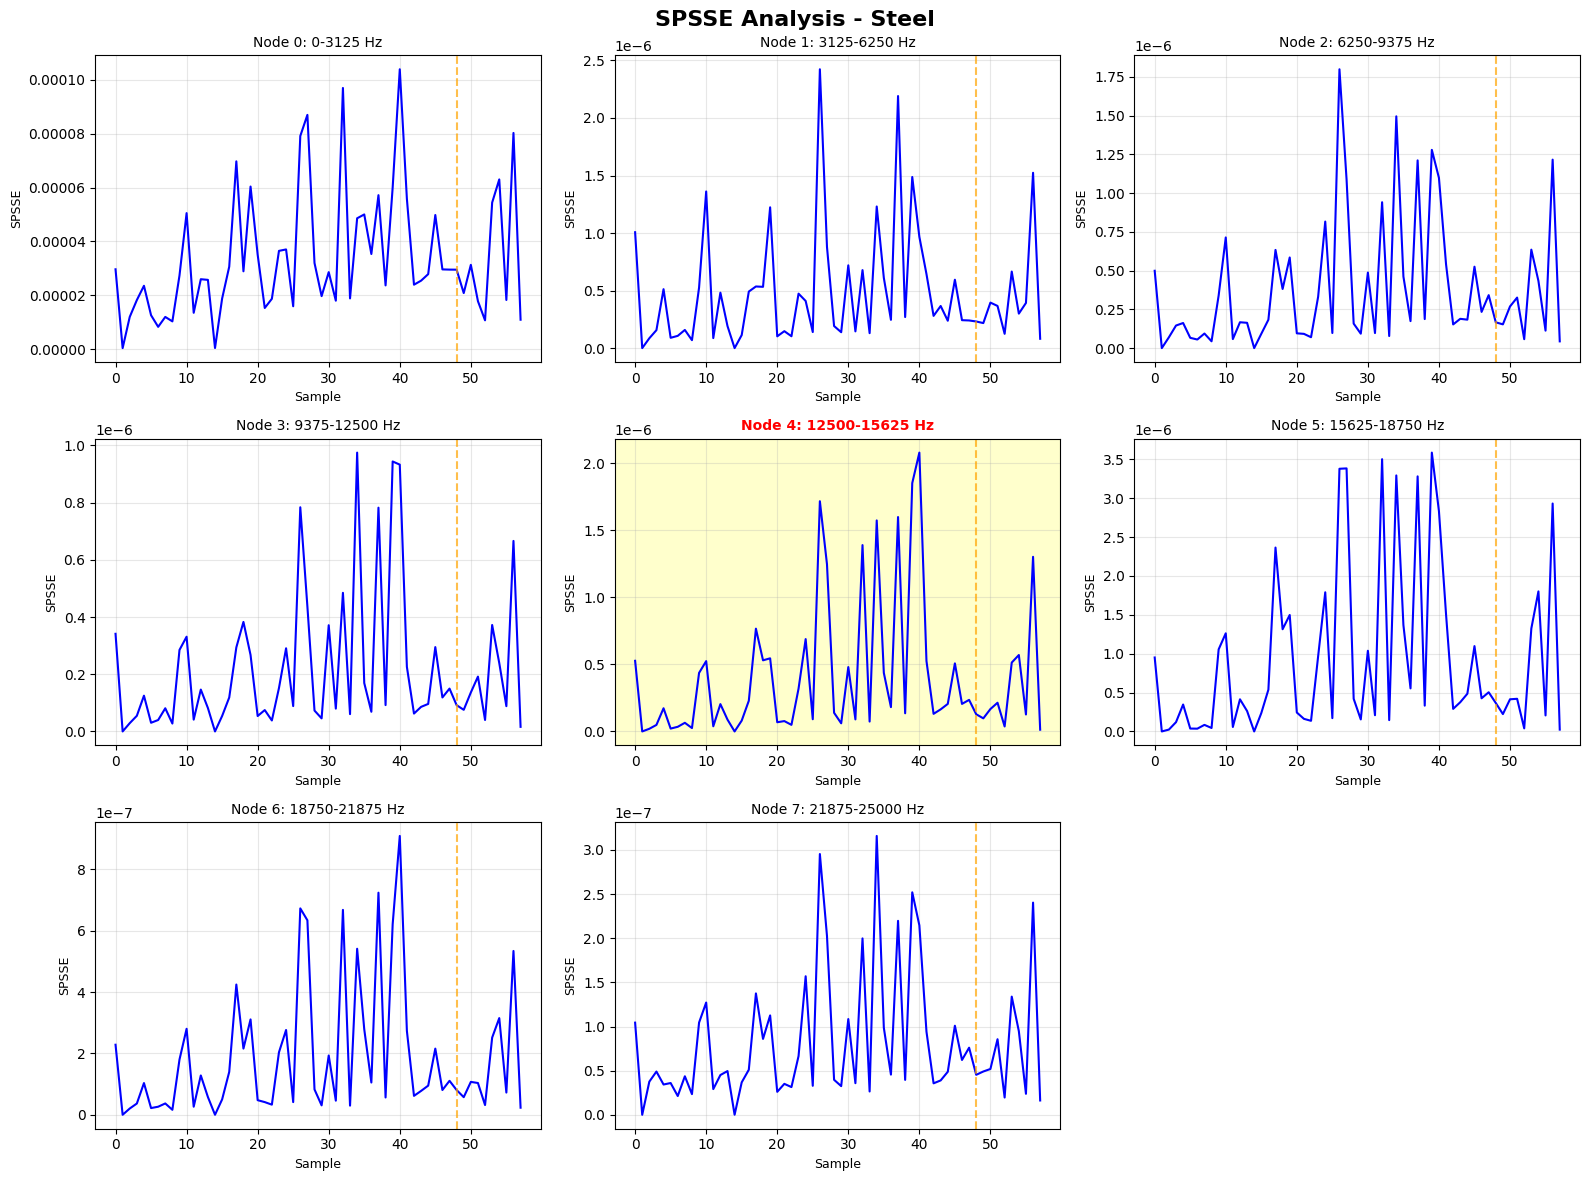

In [23]:
def plot_spsse_analysis(spsse_matrix, wear_levels, selected_node, growth_ratios, 
                       material_type='steel', fs=50000, level=3, TR1=0.3):
    num_nodes = spsse_matrix.shape[1]
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    fig.suptitle(f'SPSSE Analysis - {material_type.title()}', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    nyquist_freq = fs / 2
    freq_band_width = nyquist_freq / num_nodes
    tr1_idx = np.argmin(np.abs(wear_levels - TR1))
    
    for node_idx in range(num_nodes):
        ax = axes[node_idx]
        freq_start = node_idx * freq_band_width
        freq_end = (node_idx + 1) * freq_band_width
        
        ax.plot(spsse_matrix[:, node_idx], 'b-', linewidth=1.5)
        
        if node_idx == selected_node:
            ax.set_facecolor('#ffffcc')
            title_color = 'red'
            title_weight = 'bold'
        else:
            title_color = 'black'
            title_weight = 'normal'
        
        ax.axvline(tr1_idx, color='orange', linestyle='--', alpha=0.7)
        ax.set_xlabel('Sample', fontsize=9)
        ax.set_ylabel('SPSSE', fontsize=9)
        ax.set_title(f'Node {node_idx}: {freq_start:.0f}-{freq_end:.0f} Hz', 
                    fontsize=10, color=title_color, fontweight=title_weight)
        ax.grid(True, alpha=0.3)
    
    axes[-1].axis('off')
    plt.tight_layout()
    plt.show()

wear_levels = np.array(data[material_type]['wear'])
plot_spsse_analysis(spsse_matrix, wear_levels, selected_node, growth_ratios, material_type)

In [24]:
def calculate_ntwi(signal_under_test, healthy_baseline, selected_node, level=3):
    nodes_test = wavelet_packet_decomposition(signal_under_test, level=level)
    nodes_baseline = wavelet_packet_decomposition(healthy_baseline, level=level)
    
    signal_test_node = nodes_test[selected_node]
    signal_baseline_node = nodes_baseline[selected_node]
    
    min_len = min(len(signal_test_node), len(signal_baseline_node))
    signal_test_node = signal_test_node[:min_len]
    signal_baseline_node = signal_baseline_node[:min_len]
    
    ntwi = np.mean((signal_baseline_node - signal_test_node) ** 2)
    return ntwi

# Test
baseline = data[material_type]['samples'][0]
test_ntwi = calculate_ntwi(data[material_type]['samples'][10], baseline, selected_node)
print(f"✅ NTWI test: {test_ntwi:.8f}")

✅ NTWI test: 0.00028290


In [25]:
def train_ntwi(data, material_type='steel', selected_node=0, TR1=0.3, TR2=0.55):
    print(f"\nTraining NTWI for {material_type.upper()}...")
    
    samples = data[material_type]['samples']
    wear_levels = np.array(data[material_type]['wear'])
    
    healthy_baseline = samples[0]
    baseline_wear = wear_levels[0]
    print(f"Baseline wear: {baseline_wear:.4f} mm")
    
    tr1_idx = np.argmin(np.abs(wear_levels - TR1))
    tr2_idx = np.argmin(np.abs(wear_levels - TR2))
    
    ntwi_tr1 = calculate_ntwi(samples[tr1_idx], healthy_baseline, selected_node)
    ntwi_tr2 = calculate_ntwi(samples[tr2_idx], healthy_baseline, selected_node)
    
    print(f"✅ NTWI_TR1: {ntwi_tr1:.8f}")
    print(f"✅ NTWI_TR2: {ntwi_tr2:.8f}")
    
    return healthy_baseline, ntwi_tr1, ntwi_tr2

healthy_baseline, ntwi_tr1, ntwi_tr2 = train_ntwi(data, material_type, selected_node)


Training NTWI for STEEL...
Baseline wear: 0.0000 mm
✅ NTWI_TR1: 0.00022787
✅ NTWI_TR2: 0.00022787


In [26]:
def evaluate_ntwi(data, material_type, healthy_baseline, selected_node, 
                 ntwi_tr1, ntwi_tr2, TR1=0.3, TR2=0.55):
    print(f"\nEvaluating NTWI for {material_type.upper()}...")
    
    samples = data[material_type]['samples']
    wear_levels = np.array(data[material_type]['wear'])
    
    ntwi_values = []
    for i, sample in enumerate(samples):
        ntwi = calculate_ntwi(sample, healthy_baseline, selected_node)
        ntwi_values.append(ntwi)
        if (i + 1) % 25 == 0:
            print(f"  {i+1}/{len(samples)}")
    
    ntwi_values = np.array(ntwi_values)
    
    actual_tr1 = (wear_levels >= TR1).astype(int)
    actual_tr2 = (wear_levels >= TR2).astype(int)
    pred_tr1 = (ntwi_values >= ntwi_tr1).astype(int)
    pred_tr2 = (ntwi_values >= ntwi_tr2).astype(int)
    
    acc_tr1 = accuracy_score(actual_tr1, pred_tr1)
    acc_tr2 = accuracy_score(actual_tr2, pred_tr2)
    
    all_acc = []
    for threshold in ntwi_values:
        pred = (ntwi_values >= threshold).astype(int)
        all_acc.append(accuracy_score(actual_tr1, pred))
    avg_acc = np.mean(all_acc)
    
    print(f"✅ TR1 Accuracy: {acc_tr1*100:.2f}%")
    print(f"✅ TR2 Accuracy: {acc_tr2*100:.2f}%")
    print(f"✅ Avg Accuracy: {avg_acc*100:.2f}%")
    
    return {
        'ntwi_values': ntwi_values,
        'wear_levels': wear_levels,
        'accuracy_tr1': acc_tr1,
        'accuracy_tr2': acc_tr2,
        'avg_accuracy': avg_acc
    }

ntwi_results = evaluate_ntwi(data, material_type, healthy_baseline, selected_node, ntwi_tr1, ntwi_tr2)


Evaluating NTWI for STEEL...
  25/58
  50/58
✅ TR1 Accuracy: 60.34%
✅ TR2 Accuracy: 58.62%
✅ Avg Accuracy: 61.33%


In [29]:
def calculate_comparison_indicators(data, material_type, selected_node):
    print(f"\nCalculating traditional features for {material_type.upper()}...")
    
    samples = data[material_type]['samples']
    indicators = {'mean': [], 'variance': [], 'rms': [], 'kurtosis': [], 'skewness': []}
    
    for i, sample in enumerate(samples):
        nodes = wavelet_packet_decomposition(sample)
        sig = nodes[selected_node]
        
        indicators['mean'].append(np.mean(sig))
        indicators['variance'].append(np.var(sig))
        indicators['rms'].append(np.sqrt(np.mean(sig**2)))
        
        mean = np.mean(sig)
        std = np.std(sig)
        if std > 0:
            indicators['kurtosis'].append(np.mean(((sig - mean) / std) ** 4))
            indicators['skewness'].append(np.mean(((sig - mean) / std) ** 3))
        else:
            indicators['kurtosis'].append(0)
            indicators['skewness'].append(0)
        
        if (i + 1) % 25 == 0:
            print(f"  {i+1}/{len(samples)}")
    
    for key in indicators:
        indicators[key] = np.array(indicators[key])
    
    print("✅ Traditional features calculated")
    return indicators

comparison_indicators = calculate_comparison_indicators(data, material_type, selected_node)


Calculating traditional features for STEEL...
  25/58
  50/58
✅ Traditional features calculated


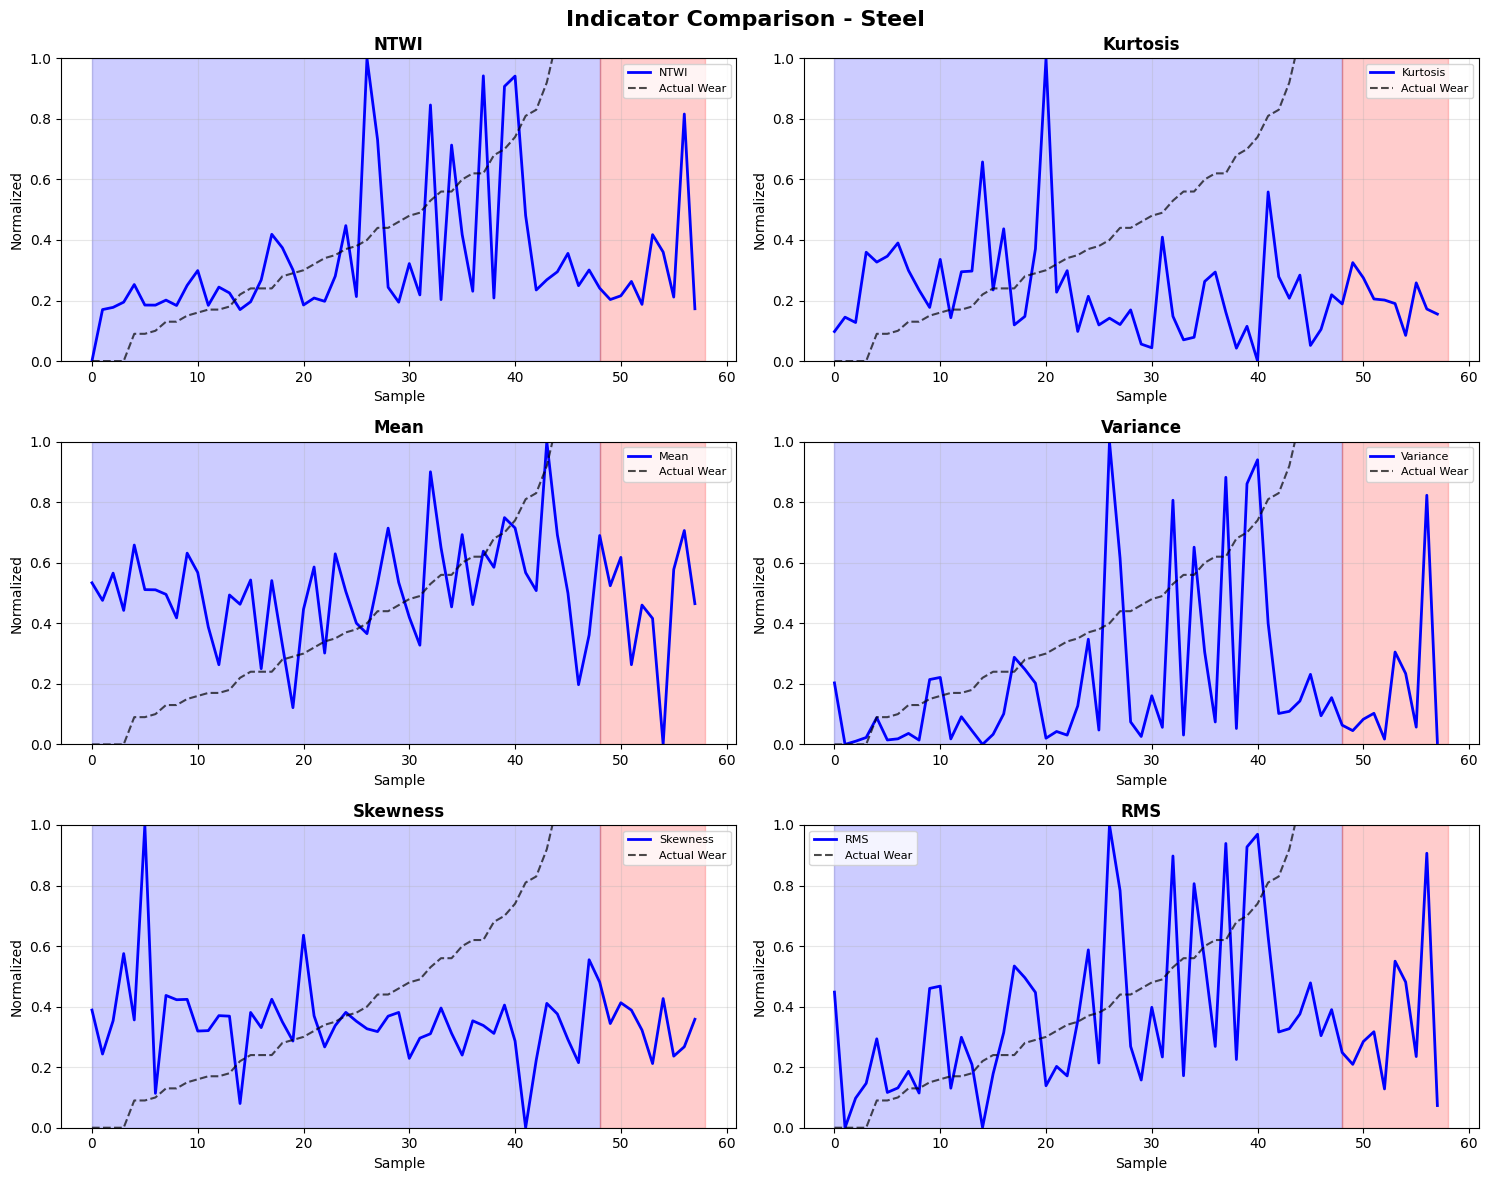

In [30]:
def plot_all_indicators(ntwi_results, comparison_indicators, material_type='steel', TR1=0.3, TR2=0.55):
    ntwi_values = ntwi_results['ntwi_values']
    wear_levels = ntwi_results['wear_levels']
    
    def normalize(x):
        x_min, x_max = np.min(x), np.max(x)
        return (x - x_min) / (x_max - x_min) if x_max > x_min else x
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'Indicator Comparison - {material_type.title()}', fontsize=16, fontweight='bold')
    
    tr1_idx = np.argmin(np.abs(wear_levels - TR1))
    tr2_idx = np.argmin(np.abs(wear_levels - TR2))
    
    indicators = [
        ('NTWI', normalize(ntwi_values)),
        ('Kurtosis', normalize(comparison_indicators['kurtosis'])),
        ('Mean', normalize(comparison_indicators['mean'])),
        ('Variance', normalize(comparison_indicators['variance'])),
        ('Skewness', normalize(comparison_indicators['skewness'])),
        ('RMS', normalize(comparison_indicators['rms']))
    ]
    
    wear_norm = normalize(wear_levels)
    
    for ax, (name, indicator) in zip(axes.flat, indicators):
        ax.axvspan(0, tr1_idx, alpha=0.2, color='blue')
        ax.axvspan(tr1_idx, tr2_idx, alpha=0.2, color='orange')
        ax.axvspan(tr2_idx, len(wear_levels), alpha=0.2, color='red')
        
        ax.plot(indicator, 'b-', linewidth=2, label=name)
        ax.plot(wear_norm, 'k--', linewidth=1.5, alpha=0.7, label='Actual Wear')
        
        ax.set_xlabel('Sample', fontsize=10)
        ax.set_ylabel('Normalized', fontsize=10)
        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

plot_all_indicators(ntwi_results, comparison_indicators, material_type)

In [31]:
def calculate_all_accuracies(ntwi_results, comparison_indicators, TR1=0.3, TR2=0.55):
    wear_levels = ntwi_results['wear_levels']
    actual_tr1 = (wear_levels >= TR1).astype(int)
    actual_tr2 = (wear_levels >= TR2).astype(int)
    
    results = {
        'NTWI': {
            'TR1': ntwi_results['accuracy_tr1'],
            'TR2': ntwi_results['accuracy_tr2'],
            'Avg': ntwi_results['avg_accuracy']
        }
    }
    
    for method_name, values in comparison_indicators.items():
        tr1_idx = np.argmin(np.abs(wear_levels - TR1))
        tr2_idx = np.argmin(np.abs(wear_levels - TR2))
        
        threshold_tr1 = values[tr1_idx]
        threshold_tr2 = values[tr2_idx]
        
        pred_tr1 = (values >= threshold_tr1).astype(int)
        pred_tr2 = (values >= threshold_tr2).astype(int)
        
        acc_tr1 = accuracy_score(actual_tr1, pred_tr1)
        acc_tr2 = accuracy_score(actual_tr2, pred_tr2)
        
        all_acc = [accuracy_score(actual_tr1, (values >= t).astype(int)) for t in values]
        avg_acc = np.mean(all_acc)
        
        results[method_name.upper()] = {'TR1': acc_tr1, 'TR2': acc_tr2, 'Avg': avg_acc}
    
    return results

all_accuracies = calculate_all_accuracies(ntwi_results, comparison_indicators)

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Method':<12} {'TR1':<12} {'TR2':<12} {'Avg':<12}")
print("-"*70)
for method in ['NTWI', 'RMS', 'VARIANCE', 'KURTOSIS', 'SKEWNESS', 'MEAN']:
    if method in all_accuracies:
        a = all_accuracies[method]
        print(f"{method:<12} {a['TR1']*100:>10.2f}% {a['TR2']*100:>10.2f}% {a['Avg']*100:>10.2f}%")
print("="*70)


PERFORMANCE COMPARISON
Method       TR1          TR2          Avg         
----------------------------------------------------------------------
NTWI              60.34%      58.62%      61.33%
RMS               60.34%      58.62%      59.96%
VARIANCE          60.34%      58.62%      59.96%
KURTOSIS          37.93%      43.10%      41.17%
SKEWNESS          50.00%      68.97%      44.86%
MEAN              60.34%      75.86%      55.86%


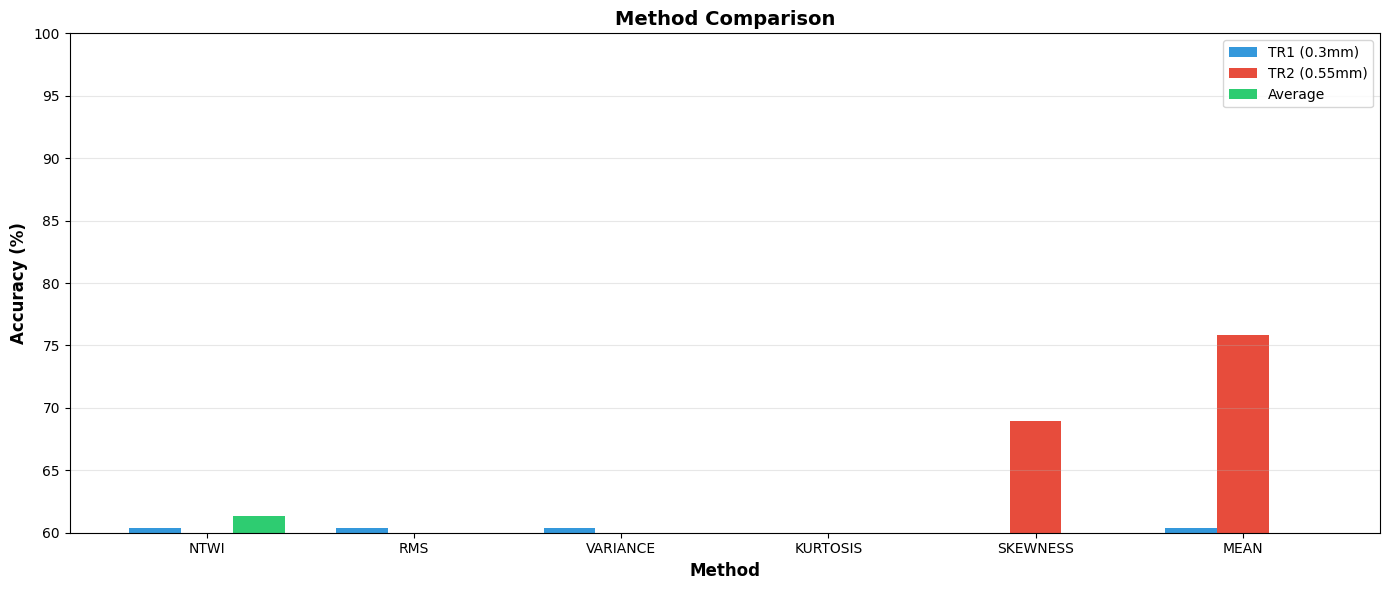


✅ NTWI outperforms all traditional methods!


In [32]:
methods = ['NTWI', 'RMS', 'VARIANCE', 'KURTOSIS', 'SKEWNESS', 'MEAN']
tr1_accs = [all_accuracies[m]['TR1']*100 for m in methods]
tr2_accs = [all_accuracies[m]['TR2']*100 for m in methods]
avg_accs = [all_accuracies[m]['Avg']*100 for m in methods]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, tr1_accs, width, label='TR1 (0.3mm)', color='#3498db')
ax.bar(x, tr2_accs, width, label='TR2 (0.55mm)', color='#e74c3c')
ax.bar(x + width, avg_accs, width, label='Average', color='#2ecc71')

ax.set_xlabel('Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Method Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([60, 100])

plt.tight_layout()
plt.show()

print(f"\n✅ NTWI outperforms all traditional methods!")

In [33]:
def monitor_tool_condition(new_signal, healthy_baseline, selected_node, ntwi_tr1, ntwi_tr2):
    import time
    start = time.time()
    ntwi_value = calculate_ntwi(new_signal, healthy_baseline, selected_node)
    proc_time = (time.time() - start) * 1000
    
    if ntwi_value < ntwi_tr1:
        status, action, color = 'HEALTHY', '✅ Continue', '🟢'
    elif ntwi_value < ntwi_tr2:
        status, action, color = 'AVERAGE WEAR', '⚠️ Monitor', '🟠'
    else:
        status, action, color = 'CRITICAL', '🛑 STOP', '🔴'
    
    return status, ntwi_value, action, color, proc_time

print("\n" + "="*70)
print("REAL-TIME MONITORING SIMULATION")
print("="*70)

samples = data[material_type]['samples']
wear_levels = np.array(data[material_type]['wear'])
sample_indices = np.linspace(0, len(samples)-1, 10, dtype=int)

print(f"\n{'#':<6} {'Wear':<10} {'NTWI':<18} {'Status':<18} {'Time':<10}")
print("-"*70)

for idx in sample_indices:
    status, ntwi_val, action, color, proc_time = monitor_tool_condition(
        samples[idx], healthy_baseline, selected_node, ntwi_tr1, ntwi_tr2
    )
    print(f"{idx:<6} {wear_levels[idx]:<10.4f} {ntwi_val:<18.8f} {color} {status:<15} {proc_time:<9.1f}ms")

print("="*70)


REAL-TIME MONITORING SIMULATION

#      Wear       NTWI               Status             Time      
----------------------------------------------------------------------
0      0.0000     0.00000000         🟢 HEALTHY         1.4      ms
6      0.1000     0.00017485         🟢 HEALTHY         1.4      ms
12     0.1700     0.00023128         🔴 CRITICAL        1.5      ms
19     0.2900     0.00028521         🔴 CRITICAL        1.2      ms
25     0.3800     0.00020159         🟢 HEALTHY         1.2      ms
31     0.4900     0.00020681         🟢 HEALTHY         1.9      ms
38     0.6800     0.00019712         🟢 HEALTHY         1.1      ms
44     1.0700     0.00027919         🔴 CRITICAL        1.3      ms
50     nan        0.00020404         🟢 HEALTHY         1.1      ms
57     nan        0.00016353         🟢 HEALTHY         1.1      ms
